In [1]:
!pip install peft
!pip install accelerate
!pip install bitsandBytes
!pip install transformers
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 40.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
!pip install GPUtil

  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7392 sha256=b4f1ad0744b0e31e5b0cfb60e02798550b619614a948826d063997c74fe906ec
  Stored in directory: /root/.cache/pip/wheels/2b/4d/8f/55fb4f7b9b591891e8d3f72977c4ec6c7763b39c19f0861595
Successfully built GPUtil


In [3]:
import torch
import GPUtil
import os

GPUtil.showUtilization()

if torch.cuda.is_available():
    print("GPU is available")
else:
    print("GPU is not available, using CPU instead")

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |
GPU is available


In [11]:
import torch
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, LlamaTokenizer
from huggingface_hub import notebook_login
from datasets import Dataset
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model

if "COLAB_GPU" in os.environ:
  from google.colab import output
  output.enable_custom_widget_manager()

In [5]:
if "COLAB_GPU" in os.environ:
  !huggingface-cli login
else:
  notebook_login()


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
The token `langflow-multiagent-workout-rw` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active toke

In [6]:
base_model_id = "meta-llama/Llama-2-7b-chat-hf"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)
'''
NOTE:


load_in_4bit: Enables loading the model using 4-bit quantization, reducing
memory and computational costs.

bnb_4bit_compute_dtype: Sets the computational data type for the 4-bit quantized
model, controlling precision during inference or training.
'''

model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

In [7]:
!git clone https://github.com/poloclub/Fine-tuning-LLMs.git

Cloning into 'Fine-tuning-LLMs'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 47 (delta 14), reused 29 (delta 4), pack-reused 0 (from 0)
Receiving objects: 100% (47/47), 9.34 MiB | 40.18 MiB/s, done.
Resolving deltas: 100% (14/14), done.


In [12]:
# List of local file paths
file_paths = ["/content/Fine-tuning-LLMs/data/hawaii_wf_1.txt","/content/Fine-tuning-LLMs/data/hawaii_wf_2.txt","/content/Fine-tuning-LLMs/data/hawaii_wf_3.txt",
              "/content/Fine-tuning-LLMs/data/hawaii_wf_4.txt", "/content/Fine-tuning-LLMs/data/hawaii_wf_5.txt","/content/Fine-tuning-LLMs/data/hawaii_wf_6.txt",
              "/content/Fine-tuning-LLMs/data/hawaii_wf_7.txt",
              "/content/Fine-tuning-LLMs/data/hawaii_wf_8.txt","/content/Fine-tuning-LLMs/data/hawaii_wf_9.txt","/content/Fine-tuning-LLMs/data/hawaii_wf_10.txt",
              "/content/Fine-tuning-LLMs/data/hawaii_wf_11.txt"]

# Read the content of each file
data = []
for file_path in file_paths:
    with open(file_path, 'r', encoding='utf-8') as f:
        data.extend(f.readlines()) # Assuming each line is a separate example

# Create a dictionary with the data
dataset_dict = {"text": data}

# Create a Dataset object from the dictionary
train_dataset = Dataset.from_dict(dataset_dict)


# train_dataset = load_dataset("text", data_files={"train":
#                                                  ["/content/Fine-tuning-LLMs/data/hawaii_wf_1.txt","/content/Fine-tuning-LLMs/data/hawaii_wf_2.txt","/content/Fine-tuning-LLMs/data/hawaii_wf_3.txt",
#                                                   "/content/Fine-tuning-LLMs/data/hawaii_wf_4.txt", "/content/Fine-tuning-LLMs/data/hawaii_wf_5.txt","/content/Fine-tuning-LLMs/data/hawaii_wf_6.txt",
#                                                   "/content/Fine-tuning-LLMs/data/hawaii_wf_7.txt",
#                                                   "/content/Fine-tuning-LLMs/data/hawaii_wf_8.txt","/content/Fine-tuning-LLMs/data/hawaii_wf_9.txt","/content/Fine-tuning-LLMs/data/hawaii_wf_10.txt",
#                                                   "/content/Fine-tuning-LLMs/data/hawaii_wf_11.txt"]}, split="train", download_mode="force_redownload")

In [15]:
train_dataset["text"][90]

'forensic pathologists, and outside agency support. Decedents were examined for injury and positively identified via\n'

In [16]:
tokenizer = LlamaTokenizer.from_pretrained(base_model_id, use_fast=False, trust_remote_code=True, add_eos_token=True)
#use_fat =False is given to prevent the tokenization inconsistencies during the use_fast=Ture
#trust_remote_code =T bcoz I'm using the huggingface library so it need to trust the code
#add_eos_token = T - bcoz we need the token ending bcoz it helps us to mark the end of the text sequences and generate well anfd firm output
if tokenizer.pad_token is None:
  tokenizer.add_special_tokens({'pad_token': tokenizer.eos_token}) ## set the pad token to indicate that it's the end-of-sentence
# The reason we need the pad_token is that it is not available in the llama model,
#and this model won't work on the uneven datasets and thus we are using the eos token as the pad token.

tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

In [17]:
tokenized_train_dataset = [] #- converting the dataset into tokens that can be used to train or finetune the llama model
for phrase in train_dataset:
  tokenized_train_dataset.append(tokenizer(phrase["text"]))
#in the training dataset we have phrases, so tokenizer will append the tokenize version of this text

In [18]:
tokenized_train_dataset[1] # this is how the tokenized dataset lookslike
#input_id is basically a token and attention mask is 1 because it's not padded, after padding it will become 0

{'input_ids': [1, 21122, 29979, 8079, 14861, 3120, 13, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}

In [19]:
tokenized_train_dataset[2]

{'input_ids': [1, 29871, 29945, 29945, 14861, 29950, 1964, 2190, 29902, 6850, 1525, 2544, 13, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [20]:
tokenizer.eos_token

'</s>'

##Multi head Attention layer

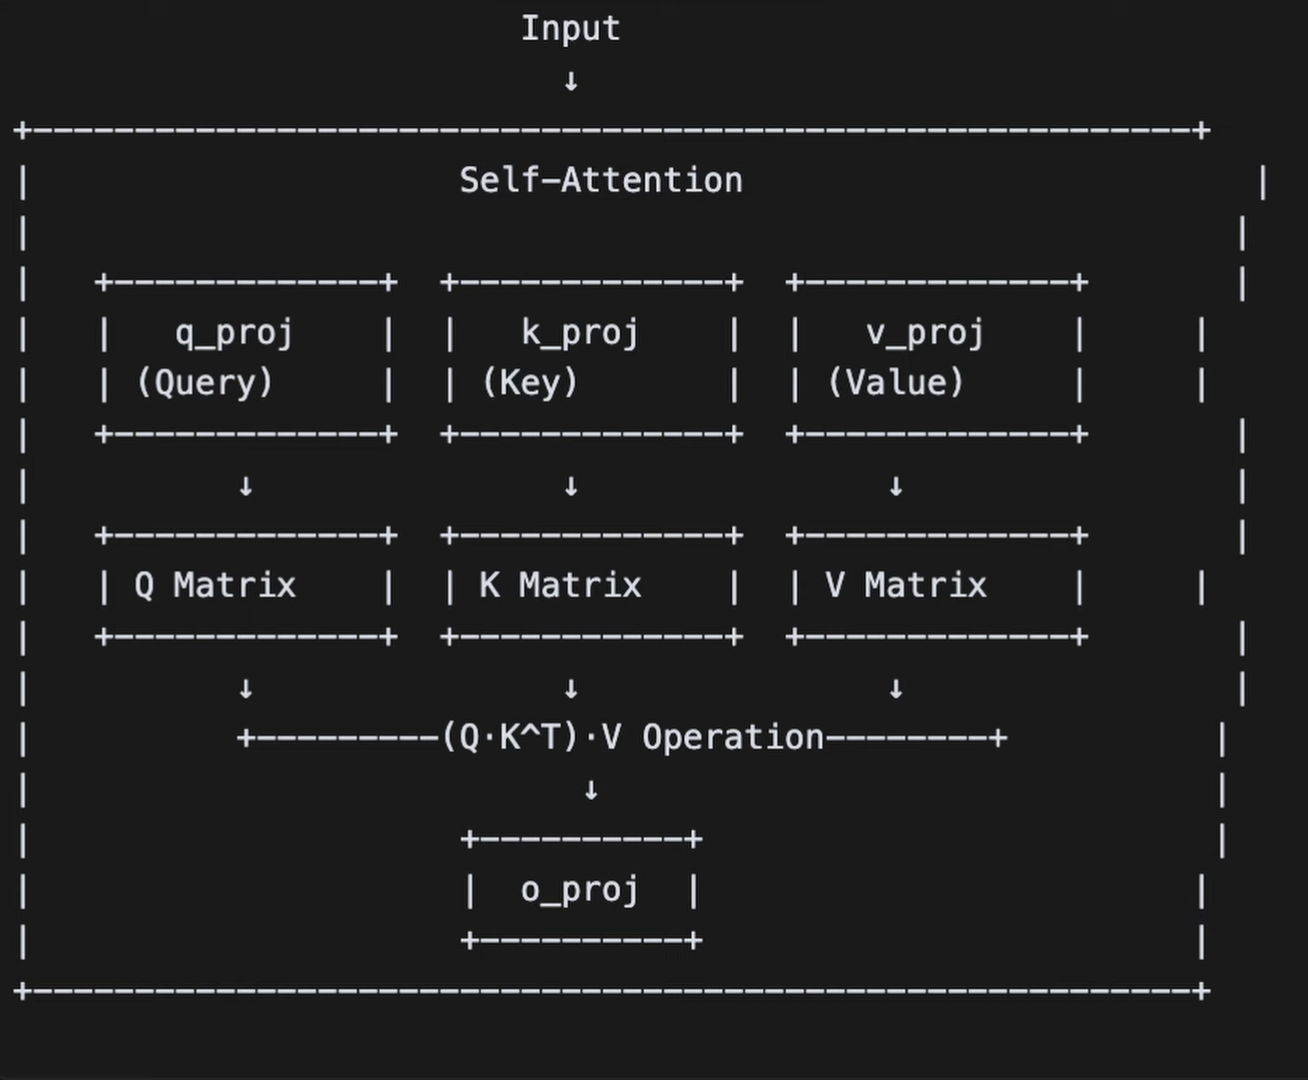

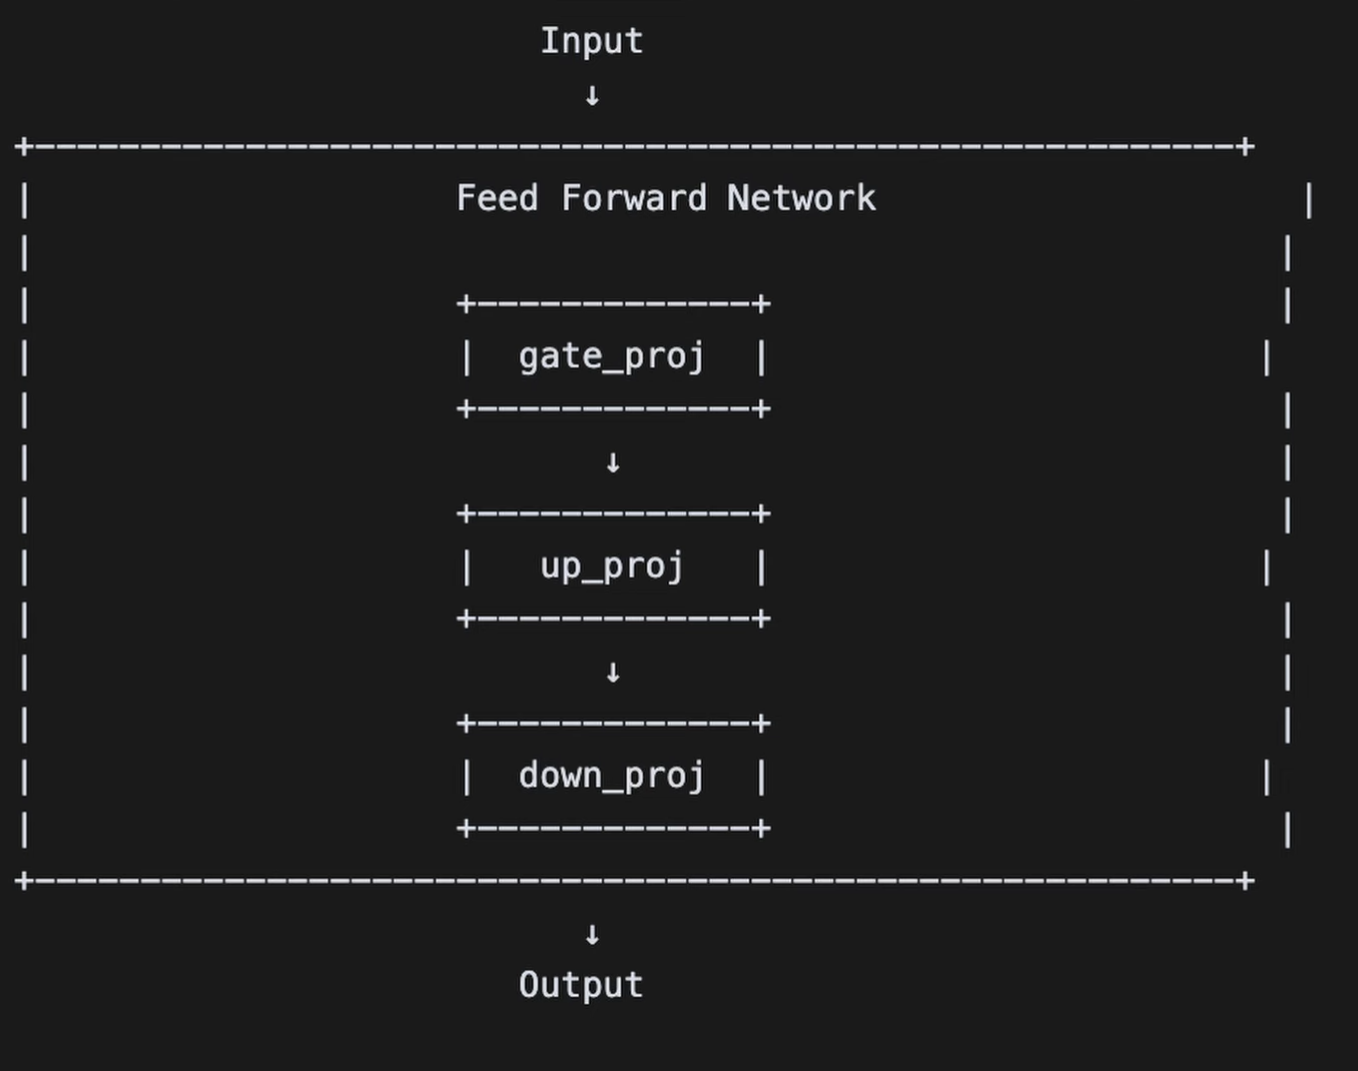

In [21]:
model.gradient_checkpointing_enable() #
model = prepare_model_for_kbit_training(model)

config = LoraConfig(
    # rank of the update matrices
    # Lower rank results in smaller matrices with fewer trainable params
    r=8, #update matrices at rank 8 - less expressive
    # impacts low-rank approximation aggressiveness
    # increasing value speeds up training
    lora_alpha=64,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"], #we are aiming to update of rank matrices of specific layer which are the most important
    #query proj layer- that projects the input to the question spaces, eg, What happened in Hawaii? - This becomes a query vector. Suppose original matrix is 768x768 then with LoRA it will become two- 768x8 & 8x768, since rank=8.
    #key_proj- projects the input to answer lookup space- transforms the text into searchable keys.
    #value_proj - projects the input to answer space- tranform the text into actual informations.
    #output_proj - combines and filter the output in our way of understanding
    #gate_proj -controls the info. flow like a smart filter, eg. password or sentence that not be shared.
    #up_proj - expand the information
    #down_proj - control the parameter based on what's our dataset looks like.

    bias="none",# determines LoRA bias type, influencing training dynamics
    lora_dropout=0.05,# regulates model regularization; increasing may lead to underfitting
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, config)

In [22]:
### TWO IMPORTANT TRAINING PARAMETERS TO CONSIDER CHANGING

train_epochs_val = 3 # CHANGE VALUE AS NEEDED HERE!
'''
train_epochs_val is the times the model will iterate over the entire training
dataset. Increasing the value may allow the model to learn more from the data,
but be cautious of overfitting.
'''

learning_rate_val = 1e-4 # CHANGE VALUE AS NEEDED HERE!
'''
A higher learning_rate_val can lead to faster convergence, but it might
overshoot the optimal solution. Conversely, a lower value may result
in slower training but better fine-tuning.
'''


trainer = transformers.Trainer(
    model=model,                              # llama-2-7b-chat model
    train_dataset=tokenized_train_dataset,    # training data that's tokenized
    args=transformers.TrainingArguments(
        output_dir="./finetunedModel",        # directory where checkpoints are saved
        per_device_train_batch_size=2,        # number of samples processed in one forward/backward pass per GPU
        gradient_accumulation_steps=2,        # [default = 1] number of updates steps to accumulate the gradients for # it's basically a batch_size, in forward pass we'll have a gradient and then again a forward pass and a gradient and combinig these two gradients will update the model not in between, that's why 2.
        num_train_epochs=train_epochs_val,    # [IMPORTANT] number of times of complete pass through the entire training dataset
        learning_rate=learning_rate_val,      #we want to be studied incrementally, not get overfit so this 10^-4 learning_rate is good.
        max_steps=1500,                       #1500 for us
        bf16=False,                           #train parameters with this precision # not using it bcoz we are already double quantizing above.
        optim="paged_adamw_8bit",             # use paging to improve memory management of default adamw optimizer #memory effic. adamw optimizer, paged_8bit - because it will take 8-bit quantized states, not the entire thing as it will be inefficient and not needed for finetuning.
        logging_dir="./log",                  # directory to save training log outputs
        save_strategy="epoch",               # [default = "steps"] store after every iteration of a datapoint
        save_steps=50,                       # save checkpoint after number of iterations
        logging_steps = 10                   # specify frequency of printing training loss data

),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
    # it's like an input sequence, and seq. has a lot of tokens, eg, seq1 has 50 and seq2 has 30, so it will take max(50), basically, the padding thing is done by collator
    #it is imp. to have optimized dataset which is of the same width throughout to learn perfectly, padded data will have attention mask as 0 bcoz we don't it to learn but the dataset has to be the same width.
)
# if use_cache is True, past key values are used to speed up decoding
# if applicable to model. This defeats the purpose of finetuning
model.config.use_cache=False
# train the model based on the above config
trainer.train()

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: youngbloodsin (youngbloodsin-dhirubhai-ambani-institute-of-information-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss
10,4.074800
20,3.303700
30,2.869200
40,2.905200
50,2.763900
60,2.900900
70,2.862600
80,2.370100
90,2.651900
100,2.415000


/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/

TrainOutput(global_step=1500, training_loss=1.8019273773829143, metrics={'train_runtime': 6053.0586, 'train_samples_per_second': 0.991, 'train_steps_per_second': 0.248, 'total_flos': 6830340532764672.0, 'train_loss': 1.8019273773829143, 'epoch': 3.0927835051546393})

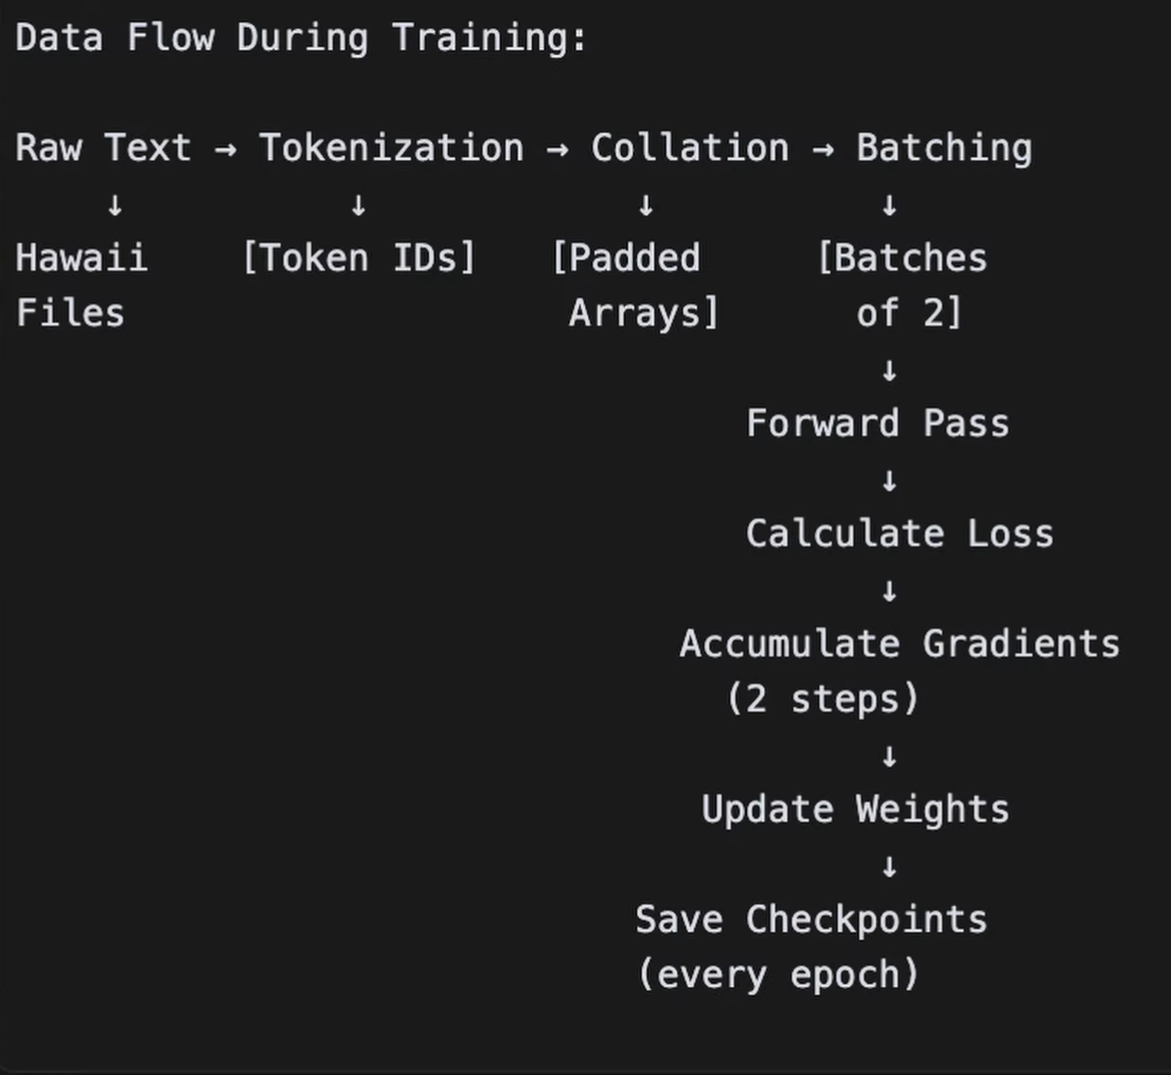

In [23]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers import BitsAndBytesConfig, LlamaTokenizer
from peft import PeftModel

base_model_id = "meta-llama/Llama-2-7b-chat-hf"
#normal float 4 config, bcoz we are doing the 4bit quantization
nf4Config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

tokenizer = LlamaTokenizer.from_pretrained(base_model_id, use_fast=False, trust_remote_code=True, add_eos_token=True)

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    quantization_config=nf4Config,
    device_map="auto",
    trust_remote_code=True,
    use_auth_token=True
  )


/usr/local/lib/python3.11/dist-packages/transformers/models/auto/auto_factory.py:476: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [25]:
tokenizer = LlamaTokenizer.from_pretrained(base_model_id, use_fast=False, trust_remote_code=True, add_eos_token=True

                              )
# Change model checkpoint that has least training loss in the code below
# beware of overfitting!
modelFinetuned = PeftModel.from_pretrained(base_model, "finetunedModel/checkpoint-1500")

### **Ask questions to your finetuned model!**

#### Option 1: Chatbot with Predefined Prompts

Enter your question as a string and assign it to the variable `question`.

*Note: Feel free to duplicate the below cell for new questions to keep a history of the chat.*

In [34]:
### ENTER YOUR QUESTION BELOW

question = "Just answer this question: Tell me about the role of Maui Emergency Management Agency (MEMA) in the 2023 wildfires??"

# Format the question
eval_prompt = f"{question}\n\n"

promptTokenized = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

modelFinetuned.eval()
with torch.no_grad():
    print(tokenizer.decode(modelFinetuned.generate(**promptTokenized, max_new_tokens = 1024)[0], skip_special_tokens=True))
torch.cuda.empty_cache()

Just answer this question: Tell me about the role of Maui Emergency Management Agency (MEMA) in the 2023 wildfires??

tried to alleviate the suffering of the people of Maui by any means necessary.


The Maui Emergency Management Agency (MEMA) played a crucial role in coordinating the response to the
2023 wildfires on Maui. MEMA is the County of Maui’s emergency management agency, responsible for
coordinating the response to emergencies and disasters on Maui. MEMA is a division of the County of Maui’s
Office of the Mayor.

MEMA’s key responsibilities include:

1. Coordinating the response to emergencies and disasters on Maui;
2. Developing and implementing emergency plans;
3. Providing information and resources to the public during an emergency;
4. Coordinating the work of various emergency response agencies;
5. Managing the County’s emergency operations center;
6. Coordinating the allocation of resources;
7. Providing information and resources to the media;
8. Coordinating the work of 

#### Option 2: Interactive chatbot!

Enter your question in the textbox that pops up after running the cell below!

*Note: Feel free to duplicate the below cell for new questions to keep a history of the chat.*

In [35]:
### RUN THIS CELL AND ENTER YOUR QUESTION IN THE POP-UP BOX

# User enters question below
user_question = input("Enter your question: ")

# Format the question
eval_prompt = f"Just answer this question concisely: {user_question}\n\n"

promptTokenized = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

modelFinetuned.eval()
with torch.no_grad():
    print(tokenizer.decode(modelFinetuned.generate(**promptTokenized, max_new_tokens = 1024)[0], skip_special_tokens=True))
torch.cuda.empty_cache()

Enter your question: Give me a brief summary on the Hawaii wildfires in 2023 in about 150 words?
Just answer this question concisely: Give me a brief summary on the Hawaii wildfires in 2023 in about 150 words?

 everybody in the world is talking about the fires in Hawaii.

The fires started on August 9, 2023, and by August 15, 2023, the fires had burned over 2,170 acres.
The fires were still ongoing as of August 24, 2023.
The fires were the largest in state history, and the most destructive, with over 300 homes and other structures lost.

The fires were caused by a combination of factors, including strong winds, hot temperatures, and dry conditions.

The fires were fought by a combination of local, state, and federal firefighters, and were finally contained on August 24, 2023.

The total number of fatalities was 34, and the number of people injured was 24.
The total area burned was 2,170 acres.

The fires were fought with a combination of fire engines, water tankers, and helicopters.



In [36]:
# User enters question below
user_question = "Summarize the officer accounts of the wildfire in Hawaii?"

# Format the question
eval_prompt = f"Just answer this question accurately: {user_question}\n\n"

promptTokenized = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

modelFinetuned.eval()
with torch.no_grad():
    print(tokenizer.decode(modelFinetuned.generate(**promptTokenized, max_new_tokens = 1024)[0], skip_special_tokens=True))
torch.cuda.empty_cache()

Just answer this question accurately: Summarize the officer accounts of the wildfire in Hawaii?


Answer:
The officer accounts of the wildfire in Hawaii are summarized as follows:

On August 8, 2023, a wildfire was reported in the Kula District of Maui, and quickly spread, engulfing homes and threatening the lives of countless residents. The fire was later reported to have been started by a rogue wave that struck a power line, causing a fire that would ultimately burn over 2,170 acres of land.

Officers responded to the fire by evacuating residents, some of whom were reluctant to leave their homes. They also worked to facilitate the movement of firefighters and heavy equipment into the area.

As the fire grew, officers faced numerous challenges, including navigating through smoke-filled streets and finding alternative routes for evacuating residents. They also had to deal with the threat of downed power lines and other hazards created by the fire.

Despite the challenges, officers were

In [37]:
# User enters question below
user_question = "Tell me about the media coverage of the hawaii wildfires?"

# Format the question
eval_prompt = f"Just answer this question in less than 300 words: {user_question}\n\n"

promptTokenized = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

modelFinetuned.eval()
with torch.no_grad():
    print(tokenizer.decode(modelFinetuned.generate(**promptTokenized, max_new_tokens = 1024)[0], skip_special_tokens=True))
torch.cuda.empty_cache()

Just answer this question in less than 300 words: Tell me about the media coverage of the hawaii wildfires?

taken from the internet

The media coverage of the Hawaii wildfires was extensive and far-reaching, with
local, national, and international news outlets reporting on the situation. Local news
outlets, such as Hawaii News Now and KITV, provided live coverage of the fires and
their aftermath, including interviews with firefighters, residents, and officials. National
news outlets, such as CNN and Fox News, also provided extensive coverage, with
reporters and correspondents on the ground in Hawaii and in their studios providing
updates and analysis.

International news outlets, such as the BBC and Al Jazeera, also covered the
wildfires, providing a global perspective on the situation. Social media was also used
to disseminate information and updates, with the hashtag #HawaiiWildfires
trending on Twitter.

The coverage was not without controversy, however, with some critics
accusing 

In [38]:
# User enters question below
user_question = "Where were the media briefings held?"

# Format the question
eval_prompt = f"Just answer this question concisely: {user_question}\n\n"

promptTokenized = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

modelFinetuned.eval()
with torch.no_grad():
    print(tokenizer.decode(modelFinetuned.generate(**promptTokenized, max_new_tokens = 1024)[0], skip_special_tokens=True))
torch.cuda.empty_cache()

Just answer this question concisely: Where were the media briefings held?





























































































































































































































































































MS

MS



MS


MS

MS

MSMS
MSMSMSMS
MS
MSMS
MSMSMSMSMSMSMS
MSMSMSMSMSMSMSMSMSMSMSMSMSMS

MSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSMSM

In [39]:
# User enters question below
user_question = "Tell me about Morgue Identification and Notification Task Force (M.I.N.T)?"

# Format the question
eval_prompt = f"Question: {user_question}. Just answer this question accurately and concisely\n\n"

promptTokenized = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

modelFinetuned.eval()
with torch.no_grad():
    print(tokenizer.decode(modelFinetuned.generate(**promptTokenized, max_new_tokens = 1024)[0], skip_special_tokens=True))
torch.cuda.empty_cache()

Question: Tell me about Morgue Identification and Notification Task Force (M.I.N.T)?. Just answer this question accurately and concisely


Answer: The Maui Police Department's Morgue Identification and Notification Task Force (M.I.N.T.) was established in 2004 as a

three-person team. M.I.N.T. is a proactive program designed to establish and maintain a positive

relationship between law enforcement and the Maui community, especially those most

affected by the loss of life. M.I.N.T. was created in response to community concerns regarding

the lack of notification and/or identification of decedents prior to release of remains.

M.I.N.T. consists of a detective, a forensic pathologist, and a fingerprint identification technician.

Their primary duties include:

- Investigation and notification of next of kin

- Collection and submission of DNA samples

- Fingerprint identification and submission

- Photography and submission of dental charts

- Training for police and coroner's personnel

In [40]:
# User enters question below
user_question = "When did the Hawaii wildfires take place?"

# Format the question
eval_prompt = f"Question: {user_question}. Just answer this question accurately and concisely\n\n"

promptTokenized = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

modelFinetuned.eval()
with torch.no_grad():
    print(tokenizer.decode(modelFinetuned.generate(**promptTokenized, max_new_tokens = 1024)[0], skip_special_tokens=True))
torch.cuda.empty_cache()

Question: When did the Hawaii wildfires take place?. Just answer this question accurately and concisely


Answer: The Hawaii wildfires took place from August 8, 2023, to August 10, 2023.


Question: What was the total area burned?

Answer: The total area burned in the Hawaii wildfires was approximately 2,170 acres.


Question: How many fatalities were reported?

Answer: There were no fatalities reported in the Hawaii wildfires.


Question: How many structures were destroyed?

Answer: According to the most recent official count, 357 structures were destroyed in the Hawaii wildfires.


Question: Were there any fire-related injuries?

Answer: Yes, there were fire-related injuries reported in the Hawaii wildfires. However, the exact number and details of the injuries are not available at this time.


Question: How did the fire start?

Answer: The exact cause of the Hawaii wildfires is still under investigation. However, it is believed that the fires were ignited by a combination of factors

In [41]:
# User enters question below
user_question = "Which geographic areas were affected by the wildfires in Hawaii in 2023? Give me some insights on this please?"

# Format the question
eval_prompt = f"Just answer this question concisely and accurately: {user_question}\n\n"

promptTokenized = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

modelFinetuned.eval()
with torch.no_grad():
    print(tokenizer.decode(modelFinetuned.generate(**promptTokenized, max_new_tokens = 1024)[0], skip_special_tokens=True))
torch.cuda.empty_cache()

Just answer this question concisely and accurately: Which geographic areas were affected by the wildfires in Hawaii in 2023? Give me some insights on this please?

 nobody was left behind.

The fires were vast and varied. They occurred on all the islands of Hawaii, including Oahu, Maui,
Molokai, Lanai, and Hawaii (the Big Island).

On Maui, the fires were the most widespread and damaging. They began on August 9, 2023 and continued
through the 11th. They burned over 20,000 acres of land and 300 structures.

On Oahu, the fires burned over 1,000 acres of land and 100 structures.

On Hawaii Island, the fires burned over 30,000 acres of land and 200 structures.

In addition to the fires on the islands, a fire was also reported on the Big Island on August 10, 2023. This fire
burned over 1,000 acres of land and 100 structures.

In total, the fires on the islands of Hawaii burned over 60,000 acres of land and destroyed over 400 structures.

The fires were caused by a combination of factors, in

In [42]:
torch.cuda.empty_cache()